In [9]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import astropy.time
import astropy.units as u
import astropy.constants as c
import emcee
import corner

custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
                   "/DSPS_WFortino/main/custom.mplstyle")
plt.style.use(custom_mplstyle)

In [16]:
# Path to OGLE data: 
OGLE_CSV = ("https://raw.githubusercontent.com/Somayeh91"
             "/Data_Science_class_UD_fall_2021"
             "/main/data/OGLE_2012_BLG_1323.csv")

# Path to Roman data:
ROMAN_CSV = ("https://raw.githubusercontent.com/Somayeh91"
              "/Data_Science_class_UD_fall_2021"
              "/main/data/mag.dcnormffp_0_82_1902.det.lc.W149.csv")

In [17]:
ogle = pd.read_csv(OGLE_CSV)
roman = pd.read_csv(ROMAN_CSV)

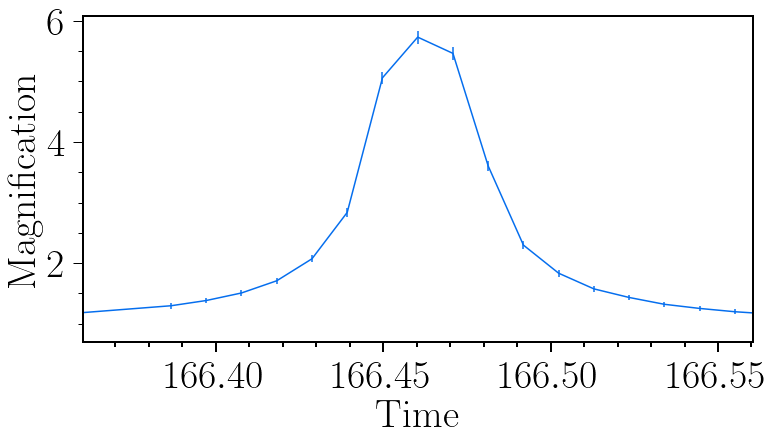

In [24]:
plt.figure(figsize=(12, 6))
plt.errorbar(roman.t, roman.A, yerr=roman.A_err*10)
peak = roman.t[np.argmax(roman.A)]

dt = 0.1
plt.xlim(peak-dt, peak+dt)

plt.xlabel("Time")
plt.ylabel("Magnification")

plt.show()

In [34]:
def PSPL(t, t0, tE, u0, fs):
    """
    PSPL Model for microlensing events.
    """
    u = np.sqrt(u0**2 +((t-t0)/tE)**2)
    A = (u**2 + 2) / (u + np.sqrt(u**2 + 4))
    F = fs * A * (1 - fs)
    return F


def cauchy(t, t0, amp, sigma, b):
    """
    Cauchy model for microlensing events.
    """
    C = amp / (1 + np.abs((t - t0) / sigma)**(2 * b))
    return C


def L1(args, x, y, func):
    return np.sum(np.abs(y - func(x, *args)))


def L2(args, x, y, func):
    return np.sum((y - func(x, *args))**2)


def chisq(args, x, y, sigma, func):
    return np.sum((y - func(x, *args))**2 / sigma**2)

L2 unit test: result should be 111.93751462 -8.33237568: [111.93751614  -8.3323759 ]
chi2 unit test: result should be 104.93611121 -7.21374685: [104.93609417  -7.21374452]


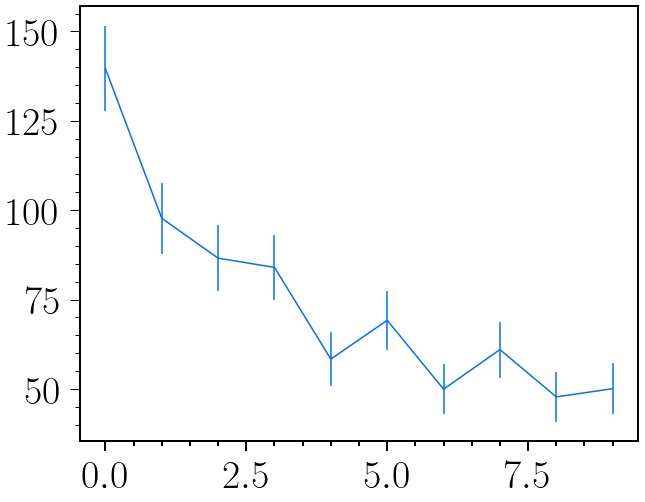

In [35]:
# Unit test
def line(a, b, x):
    return a*x + b

np.random.seed(222)
y = np.array([120, 95, 82, 74, 66, 62, 59, 51, 53, 47])
y = y + np.random.randn(len(y)) * 10
yerr = np.sqrt(y)
x = np.arange(len(y))
plt.errorbar(x, y, yerr=yerr);
print("L2 unit test: result should be 111.93751462 -8.33237568:", sp.optimize.minimize(L2, (10,40), args=(x, y, line)).x)
print("chi2 unit test: result should be 104.93611121 -7.21374685:", sp.optimize.minimize(chisq, (10,40), args=(x, y, yerr, line)).x)

In [50]:
x = roman.t.values
y = roman.A.values
sigma = roman.A_err.values

PSPL_P0 = (peak, 0.1, 0.02, 0.46)
opt_PSPL_L1 = sp.optimize.minimize(L1, PSPL_P0, args=(x, y, PSPL))
opt_PSPL_L2 = sp.optimize.minimize(L2, PSPL_P0, args=(x, y, PSPL))
opt_PSPL_chisq =sp.optimize.minimize(chisq, PSPL_P0, args=(x, y, sigma, PSPL))